In [51]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import numpy as np

In [52]:
# Load the dataset
house_data = pd.read_csv('kc_house_data.csv')
house_data.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Text(0.5, 0.4, 'Skewness: 4.024069')

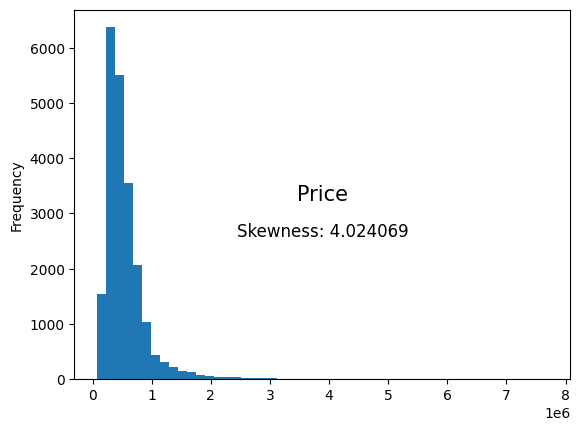

In [53]:
ax= house_data.price.plot.hist(bins=50)
ax.text(0.5, 0.5, 'Price', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
ax.text(0.5, 0.4, "Skewness: %f" % house_data.price.skew(), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

In [54]:
# Select important features and the target variable
selected_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade']
target = 'price'

# Clean the data
clean_data = house_data[selected_features + [target]].dropna()

# view the cleaned data
clean_data.head()

,bedrooms,bathrooms,sqft_living,floors,grade,price
0,3,1.00,1180,1.0,7,221900.0
1,3,2.25,2570,2.0,7,538000.0
2,2,1.00,770,1.0,6,180000.0
3,4,3.00,1960,1.0,7,604000.0
4,3,2.00,1680,1.0,8,510000.0


In [55]:
# Split data into features (X) and target (y)
X = clean_data[selected_features]
y = clean_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)  # Apply log1p to handle zero values
y_test_log = np.log1p(y_test)


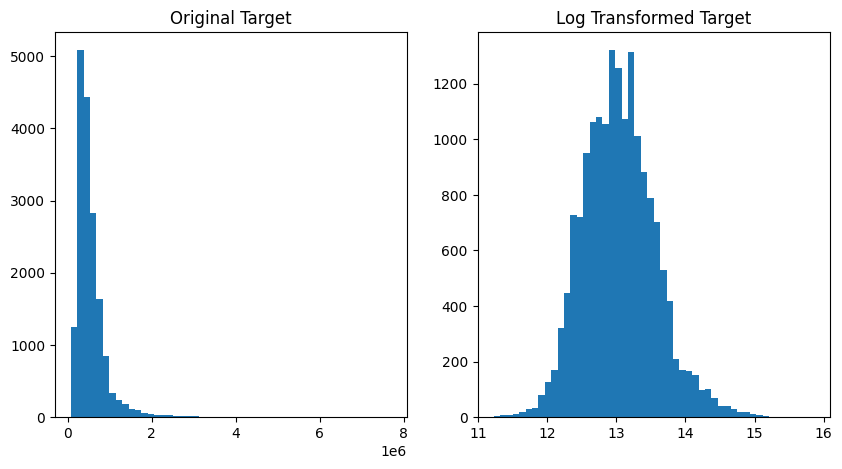

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(y_train, bins=50)
ax1.set_title('Original Target')
ax2.hist(y_train_log, bins=50)
ax2.set_title('Log Transformed Target')
plt.show()


In [57]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu',),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_scaled, y_train_log, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 141.8871 - mae: 11.6134 - val_loss: 4.4269 - val_mae: 1.6570
Epoch 2/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.0071 - mae: 1.5281 - val_loss: 2.4665 - val_mae: 1.1066
Epoch 3/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4102 - mae: 1.0769 - val_loss: 1.4363 - val_mae: 0.7297
Epoch 4/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5201 - mae: 0.7785 - val_loss: 1.0267 - val_mae: 0.5690
Epoch 5/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2037 - mae: 0.6599 - val_loss: 0.8148 - val_mae: 0.4526
Epoch 6/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0107 - mae: 0.5769 - val_loss: 0.7078 - val_mae: 0.3938
Epoch 7/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9174 - mae: 0.5387 - val_loss: 0.6458 - val_mae: 0.3650
Epoch 8/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8318 - mae: 0.5088 - val_loss: 0.5939 - val_mae: 0.3431
Epoch 9/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1

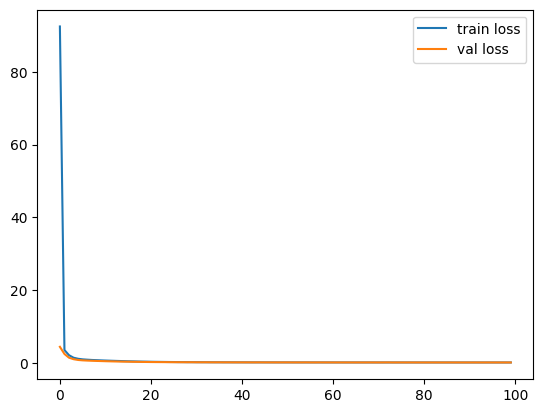

In [60]:
# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [61]:
model.evaluate(X_test_scaled, y_test_log)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 0.1257 - mae: 0.2790


[0.12199227511882782, 0.2748098075389862]

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


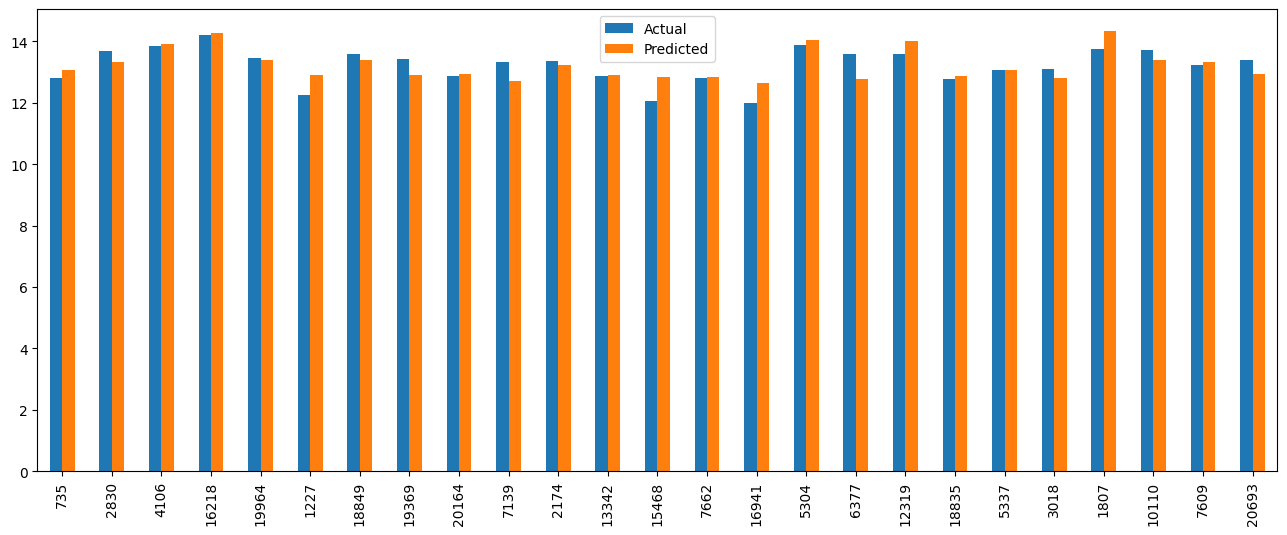

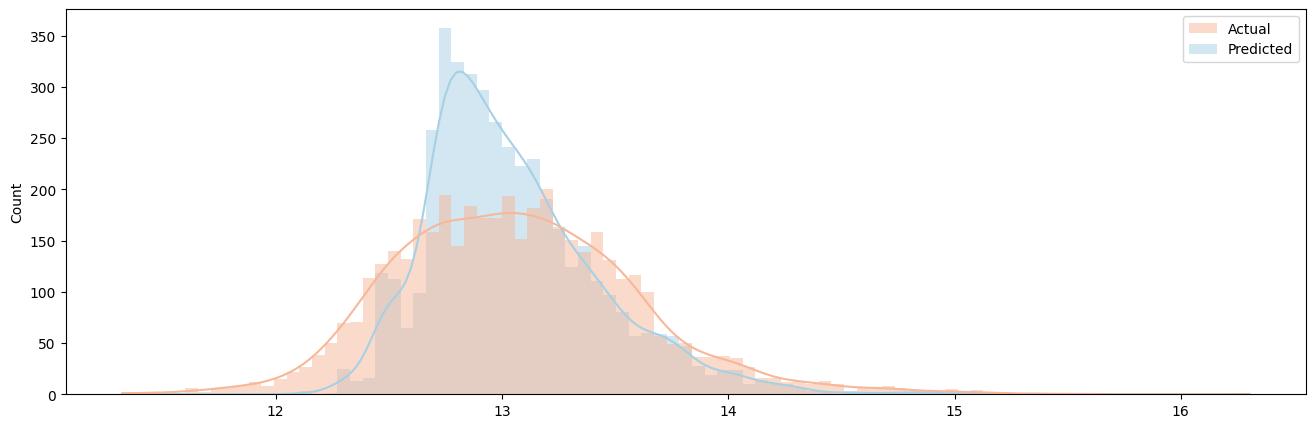

In [65]:
y_pred = model.predict(X_test_scaled)
df = pd.DataFrame({'Actual': y_test_log, 'Predicted': y_pred.flatten()})
# visualize the comparison between the actual and predicted values
fig, ax = plt.subplots()
df.head(25).plot(kind='bar',figsize=(16,6),ax=ax)
plt.show()

# kde
fig, ax = plt.subplots(figsize=(16, 5))
sns.histplot(data=df, fill=True, kde=True, palette="RdBu", alpha=.5, linewidth=0, ax=ax)
plt.show()

In [66]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('house_price_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ZAID\AppData\Local\Temp\tmpnz8_cqua\assets


INFO:tensorflow:Assets written to: C:\Users\ZAID\AppData\Local\Temp\tmpnz8_cqua\assets


Saved artifact at 'C:\Users\ZAID\AppData\Local\Temp\tmpnz8_cqua'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_23')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1716563246352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716454364880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716496321808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716358852688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716454359120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716491822544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716358855568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716358856528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716491827728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1716380744784: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [75]:
def predict_price(bedrooms, bathrooms, sqft_living, floors, grade):
    data_dict = {
        'bedrooms': [bedrooms],
        'bathrooms': [bathrooms],
        'sqft_living': [sqft_living],
        'floors': [floors],
        'grade': [grade]
    }
    data = pd.DataFrame(data_dict)
    data_scaled = scaler.transform(data)
    price_log = model.predict(data_scaled)
    return np.expm1(price_log)[0][0]